# Calculating the Dynamical Matrix using PDielec

First of all we move the examples directory of the PDielec distribution.  Directory used here should be replaced by the root directory of an installation of PDielec on your system.

In [61]:
%cd /home/john/Software/PDielec

/home/john/Software/PDielec


First of all create the reader for the outputfile that will be processed.

In [62]:
from PDielec.Utilities import find_program_from_name
from PDielec.Utilities import get_reader
file = 'Examples/Castep/Na2SO42/phonon.castep'
program = find_program_from_name(file)
reader = get_reader(file,program,'')
reader.read_output()

The reader contains information about the unit cell and all the details of the output found in the file.  To obtain the unit cell information for the last unit cell reported in the output file do the following.

In [63]:
cell = reader.unit_cells[-1]
cell.print_info()

 
Unit Cell a,b,c 
     4.780000     5.575000     6.091000
 
Unit Cell alpha,beta,gamma
   101.871000   103.337000    97.418000
 
lattice
     4.780000     0.000000     0.000000
    -0.719772     5.528341     0.000000
    -1.405061    -1.446482     5.747502
 
Element names
 O         O         O         O         O         O         O         O        
 Na        Na        S         S        
 
Fractional coords
     0.553874     0.019031     0.440862
     0.446126     0.980969     0.559138
     0.758890     0.907386     0.139814
     0.241110     0.092614     0.860186
     0.321294     0.656057     0.140675
     0.678706     0.343943     0.859325
     0.756277     0.649736     0.403633
     0.243723     0.350264     0.596367
     0.017700     0.317755     0.204064
     0.982300     0.682245     0.795936
     0.603230     0.785406     0.263766
     0.396770     0.214594     0.736234
 
Cartesian coords
     2.014382    -0.532489     2.533855
     0.640785     4.614348     3.213647
     

The masses used by the DFT codes to calculate the normal modes are often not consistent.  PDielec will use a consistent set of masses to determine the normal modes.  In this case we use the natural occuring average of isotope masses

In [64]:
from PDielec.Constants import average_masses
mass_dictionary = {}
reader.reset_masses()
reader.change_masses(average_masses,mass_dictionary)

Now use the reader to calculate the dynamical matrix, the mass weighted normal modes and the frequencies.  The reader is told to calculate the frequencies assuming Eckart conditions (that is projecting out the translational degrees of freedom from the dynamical matrix)

In [65]:
reader.eckart = True
mass_weighted_normal_modes = reader.calculate_mass_weighted_normal_modes()
frequencies_in_cm1 = reader.frequencies

We can print out the frequencies and see that we have one imaginary mode indicated by -40.205.  The next 3 modes are zero as required by the Eckart conditions.

In [66]:
frequencies_in_cm1 = reader.frequencies
for mode,freq in enumerate(frequencies_in_cm1):
    print('Mode: {:3}, frequency {:4.3f} cm-1'.format(mode,freq))

Mode:   0, frequency -40.205 cm-1
Mode:   1, frequency -0.000 cm-1
Mode:   2, frequency -0.000 cm-1
Mode:   3, frequency 0.000 cm-1
Mode:   4, frequency 72.766 cm-1
Mode:   5, frequency 81.506 cm-1
Mode:   6, frequency 103.773 cm-1
Mode:   7, frequency 110.078 cm-1
Mode:   8, frequency 121.843 cm-1
Mode:   9, frequency 125.467 cm-1
Mode:  10, frequency 165.349 cm-1
Mode:  11, frequency 188.600 cm-1
Mode:  12, frequency 192.570 cm-1
Mode:  13, frequency 199.832 cm-1
Mode:  14, frequency 210.703 cm-1
Mode:  15, frequency 216.389 cm-1
Mode:  16, frequency 239.311 cm-1
Mode:  17, frequency 331.174 cm-1
Mode:  18, frequency 351.833 cm-1
Mode:  19, frequency 477.977 cm-1
Mode:  20, frequency 496.180 cm-1
Mode:  21, frequency 525.221 cm-1
Mode:  22, frequency 537.805 cm-1
Mode:  23, frequency 559.766 cm-1
Mode:  24, frequency 577.761 cm-1
Mode:  25, frequency 613.071 cm-1
Mode:  26, frequency 687.170 cm-1
Mode:  27, frequency 712.117 cm-1
Mode:  28, frequency 985.915 cm-1
Mode:  29, frequency

The mass weight normal mode for mode 0, which had an imaginary eigenvalue, indicated by its negative frequency consists of atoms moving in x,y and z coordinates.  The example below shows that for this mode there are pairs of atoms moving in the same direction.  The largest components are associated with the first two atoms in the unit cell.

In [67]:
mass_weighted_normal_modes[0]

[[-0.401922070207739, 0.11448751178587527, -0.3372723834672907],
 [-0.4019220702077392, 0.11448751178584565, -0.33727238346730615],
 [0.0306742503493622, -0.010189114930221916, 0.024271102934127164],
 [0.030674250349374876, -0.010189114930241926, 0.024271102934085558],
 [0.18692716812922075, -0.19764207122837507, -0.07549694103849534],
 [0.18692716812927998, -0.19764207122844155, -0.0754969410386071],
 [-0.024338723790864335, 0.17647119652319376, 0.25224873387744984],
 [-0.0243387237908143, 0.17647119652310359, 0.2522487338773343],
 [0.14754095444731558, -0.08245683921157045, 0.06083214668022772],
 [0.14754095444730375, -0.0824568392114875, 0.0608321466801342],
 [0.02246278345704881, 0.011100436619370819, 0.044734229996130186],
 [0.022462783457088183, 0.011100436619288048, 0.04473422999603764]]

To calculate the infrared intensities we need to make use of the Born charges to determine the change in dipole moment for each normal mode.  The calculation is done in atomic units (au), so massess and frequencies are converted to au.
The mass weighted normal modes which are determined by diagonalising the dynamical matrix are converted to normal modes in a basis of cartesian coordinates.  The the oscillator strengths are determined from the Born charges and normal modes.  Finally the intensities are determined.  The resulting intensities are converted to the units of $ Debye^{2} \unicode{x212B}^{-2} amu^{-1} $ by the routine Calculator.infrared_intensities().

In [68]:
import numpy as np
from PDielec.Constants import wavenumber, amu
import PDielec.Calculator as Calculator
frequencies_in_au = wavenumber * np.array(frequencies_in_cm1)
born_charges = np.array(reader.born_charges)
masses = amu * np.array(reader.masses)
normal_modes = Calculator.normal_modes(masses,mass_weighted_normal_modes)
oscillator_strengths = Calculator.oscillator_strengths(normal_modes, born_charges)
intensities = Calculator.infrared_intensities(oscillator_strengths)

<StemContainer object of 3 artists>

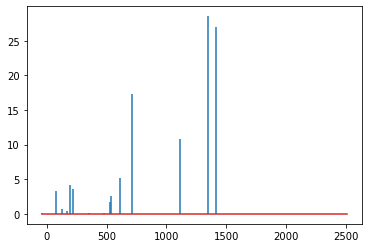

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.stem(frequencies_in_cm1,intensities,markerfmt=' ')